# DeepPurpose Deep Dive
## Tutorial 1: Training a Drug-Target Interaction Model from Scratch
#### [@KexinHuang5](https://twitter.com/KexinHuang5)

In this tutorial, we take a deep dive into DeepPurpose and show how it builds a drug-target interaction model from scratch. 

Agenda:

- Part I: Overview of DeepPurpose and Data
- Part II: Drug Target Interaction Prediction
    - DeepPurpose Framework
    - Applications to Drug Repurposing and Virtual Screening
    - Pretrained Models
    - Hyperparameter Tuning
    - Model Robustness Evaluation

Let's start!

In [2]:
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")

## Part I: Overview of DeepPurpose and Data

Drug-target interaction measures the binding of drug molecules to the protein targets. Accurate identification of DTI is fundamental for drug discovery and supports many downstream tasks. Among others, drug screening and repurposing are two main applications based on DTI. Drug screening helps identify ligand candidates that can bind to the protein of interest, whereas drug repurposing finds new therapeutic purposes for existing drugs. Both tasks could alleviate the costly, time-consuming, and labor-intensive process of synthesis and analysis, which is extremely important, especially in the cases of hunting effective and safe treatments for COVID-19.

DeepPurpose is a pytorch-based deep learning framework that is initiated to provide a simple but powerful toolkit for drug-target interaction prediction and its related applications. We see many exciting recent works in this direction, but to leverage these models, it takes lots of efforts due to the esoteric instructions and interface. DeepPurpose is designed to make things as simple as possible using a unified framework.

DeepPurpose uses an encoder-decoder framework. Drug repurposing and screening are two applications after we obtain DTI models. The input to the model is a drug target pair, where drug uses the simplified molecular-input line-entry system (SMILES) string and target uses the amino acid sequence. The output is a score indicating the binding activity of the drug target pair. Now, we begin talking about the data format expected.


(**Data**) DeepPurpose takes into an array of drug's SMILES strings (**d**), an array of target protein's amino acid sequence (**t**), and an array of label (**y**), which can either be binary 0/1 indicating interaction outcome or a real number indicating affinity value. The input drug and target arrays should be paired, i.e. **y**\[0\] is the score for **d**\[0\] and **t**\[0\].

Besides transforming into numpy arrays through some data wrangling on your own, DeepPurpose also provides two ways to help data preparation. 

The first way is to read from local files. For example, to load drug target pairs, we expect a file.txt where each line is a drug SMILES string, followed by a protein sequence, and an affinity score or 0/1 label:

```CC1=C...C4)N MKK...LIDL 7.365``` \
```CC1=C...C4)N QQP...EGKH 4.999```

Then, we use ```dataset.read_file_training_dataset_drug_target_pairs``` to load it.

In [3]:
X_drugs, X_targets, y = dataset.read_file_training_dataset_drug_target_pairs('./toy_data/dti.txt')
print('Drug 1: ' + X_drugs[0])
print('Target 1: ' + X_targets[0])
print('Score 1: ' + str(y[0]))

Drug 1: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Target 1: MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQ

Many method researchers want to test on benchmark datasets such as KIBA/DAVIS/BindingDB, DeepPurpose also provides data loaders to ease preprocessing. For example, we want to load the DAVIS dataset, we can use ```dataset.load_process_DAVIS```. It will download, preprocess to the designated data format. It supports label log-scale transformation for easier regression and also allows label binarization given a customized threshold.

In [4]:
X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
print('Drug 1: ' + X_drugs[0])
print('Target 1: ' + X_targets[0])
print('Score 1: ' + str(y[0]))

Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Drug 1: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Target 1: MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELL

For more detailed examples and tutorials of data loading, checkout this [tutorial](./DEMO/load_data_tutorial.ipynb).

## Part II: Drug Target Interaction Prediction Framework

DeepPurpose provides a simple framework to conduct DTI research using 8 encoders for drugs and 7 for proteins. It basically consists of the following steps, where each step corresponds to one line of code:

- Encoder specification
- Data encoding and split
- Model configuration generation
- Model initialization
- Model Training
- Model Prediction and Repuposing/Screening
- Model Saving and Loading

Let's start with data encoding! 

(**Encoder specification**) After we obtain the required data format from Part I, we need to prepare them for the encoders. Hence, we first specify the encoder to use for drug and protein. Here we try MPNN for drug and CNN for target.

If you find MPNN and CNN are too large for the CPUs, you can try smaller encoders by uncommenting the last line:

In [5]:
drug_encoding, target_encoding = 'Transformer', 'Transformer'
#drug_encoding, target_encoding = 'Morgan', 'Conjoint_triad'

Note that you can switch encoder just by changing the encoding name above. The full list of encoders are listed [here](https://github.com/kexinhuang12345/DeepPurpose#encodings). Here, we are using the message passing neural network encoder for drug and convolutional neural network encoder for protein.

(**Data encoding and split**) Now, we encode the data into the specified format, using ```utils.data_process``` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. This function also support data splitting methods such as ```cold_drug``` and ```cold_protein```, which splits on drug/proteins for model robustness evaluation to test on unseen drug/proteins.

The function outputs train, val, test pandas dataframes.

In [6]:
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)
train.head()

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.


,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.0,"([800, 122, 248, 282, 623, 272, 1256, 2210, 91...","([266, 23, 513, 143, 306, 78, 182, 250, 2325, ..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.0,"([800, 122, 248, 282, 623, 272, 1256, 2210, 91...","([266, 23, 513, 143, 306, 78, 182, 250, 2325, ..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.0,"([800, 122, 248, 282, 623, 272, 1256, 2210, 91...","([266, 23, 513, 143, 306, 78, 182, 250, 2325, ..."
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.0,"([800, 122, 248, 282, 623, 272, 1256, 2210, 91...","([266, 23, 513, 143, 306, 78, 182, 250, 2325, ..."
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.0,"([800, 122, 248, 282, 623, 272, 1256, 2210, 91...","([266, 23, 513, 143, 306, 78, 182, 250, 2325, ..."


In [7]:
print("train size: ", train.shape[0])
print("valid size: ", val.shape[0])
print("test size: ", test.shape[0])

train size:  21039
valid size:  3006
test size:  6011


In [8]:
first_row = train.iloc[0]
print("Drug SMILES: \n", first_row["SMILES"])
print("Drug SMILES length: \n", len(first_row["SMILES"]))
print("-"*40)
this_drug_encoding = first_row["drug_encoding"]
print("Drug Encoding: \n", this_drug_encoding)
print("non-zeros: ", this_drug_encoding[1].sum())
print("-"*40)
print("Target Sequence: \n", first_row["Target Sequence"])
print("Target Sequence length: \n", len(first_row["Target Sequence"]))
print("-"*40)
this_target_encoding = first_row["target_encoding"]
print("Target Encoding: \n", this_target_encoding)
print("non-zeros: ", this_target_encoding[1].sum())

Drug SMILES: 
 CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Drug SMILES length: 
 51
----------------------------------------
Drug Encoding: 
 (array([ 800,  122,  248,  282,  623,  272, 1256, 2210,   91,   85,  109,
        119,   80,    8,  282,  861,  209,   19,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]))
non-zeros:  18
----------------------------------------
Target Sequence: 
 PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYG

Transformer encoding method:

- Type: Byte Pair Encoding (BPE)

- Vocab size: 

    - drug: 2657 generated from Chembl (SMILES)
    - protein: 4101 generated from Uniprot (Amino Acid, one letter)


(**Model configuration generation**) Now, we initialize a model with its configuration. You can modify almost any hyper-parameters (e.g., learning rate, epoch, batch size), model parameters (e.g. hidden dimensions, filter size) and etc in this function. The supported configurations are listed here in this [link](https://github.com/kexinhuang12345/DeepPurpose/blob/e169e2f550694145077bb2af95a4031abe400a77/DeepPurpose/utils.py#L486).

For the sake of example, we specify the epoch size to be 3, and set the model parameters to be small so that you can run on both CPUs & GPUs quickly and can proceed to the next steps. For a reference parameters, checkout the notebooks in the DEMO folder.

In [9]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         LR = 0.001, 
                         batch_size = 8,
                         hidden_dim_drug = 128,
                         input_dim_drug=128, 
                         input_dim_protein=128,
                         train_epoch=5
                        )

In [10]:
config

{'input_dim_drug': 2586,
 'input_dim_protein': 4114,
 'hidden_dim_drug': 128,
 'hidden_dim_protein': 64,
 'cls_hidden_dims': [1024, 1024, 512],
 'batch_size': 8,
 'train_epoch': 5,
 'test_every_X_epoch': 20,
 'LR': 0.001,
 'drug_encoding': 'Transformer',
 'target_encoding': 'Transformer',
 'result_folder': './result/',
 'binary': False,
 'num_workers': 0,
 'transformer_emb_size_drug': 128,
 'transformer_num_attention_heads_drug': 8,
 'transformer_intermediate_size_drug': 512,
 'transformer_n_layer_drug': 8,
 'transformer_dropout_rate': 0.1,
 'transformer_attention_probs_dropout': 0.1,
 'transformer_hidden_dropout_rate': 0.1,
 'transformer_emb_size_target': 64,
 'transformer_num_attention_heads_target': 4,
 'transformer_intermediate_size_target': 256,
 'transformer_n_layer_target': 2}

(**Model initialization**) Next, we initialize a model using the above configuration.

In [11]:
model = models.model_initialize(**config)
model

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
print("Drug encoder: ")
print("-"*40)
print(model.model_drug)
print("num of params: ", count_parameters(model.model_drug))
print("-"*40)
print("Target encoder: ")
print("-"*40)
print(model.model_protein)
print("num of params: ", count_parameters(model.model_protein))

Drug encoder: 
----------------------------------------
transformer(
  (emb): Embeddings(
    (word_embeddings): Embedding(2586, 128)
    (position_embeddings): Embedding(50, 128)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder_MultipleLayers(
    (layer): ModuleList(
      (0): Encoder(
        (attention): Attention(
          (self): SelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): SelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): Intermediate(
          (dense): Linear(in_features=128, out_feature

**How to obtain Transformer embeddings?**
```
	### parameter v (tuple of length 2) is from utils.drug2emb_encoder 
	def forward(self, v):
		e = v[0].long().to(device)
		e_mask = v[1].long().to(device)
		ex_e_mask = e_mask.unsqueeze(1).unsqueeze(2)
		ex_e_mask = (1.0 - ex_e_mask) * -10000.0

		emb = self.emb(e)
		encoded_layers = self.encoder(emb.float(), ex_e_mask.float())
		return encoded_layers[:,0]
```

**How to make prediction based on embeddings?**

```
	def forward(self, v_D, v_P):
		# each encoding
		v_D = self.model_drug(v_D)
		v_P = self.model_protein(v_P)
		# concatenate and classify
		v_f = torch.cat((v_D, v_P), 1)
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f
```

(**Model Training**) Next, it is ready to train, using the ```model.train``` function! If you do not have test set, you can just use ```model.train(train, val)```. 

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 31.8204. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 2.89585. Total time 0.00305 hours
Training at Epoch 1 iteration 200 with loss 2.13076. Total time 0.00611 hours
Training at Epoch 1 iteration 300 with loss 0.27958. Total time 0.00944 hours
Training at Epoch 1 iteration 400 with loss 0.81973. Total time 0.0125 hours
Training at Epoch 1 iteration 500 with loss 3.12658. Total time 0.01555 hours
Training at Epoch 1 iteration 600 with loss 0.16494. Total time 0.01861 hours
Training at Epoch 1 iteration 700 with loss 1.06940. Total time 0.02138 hours
Training at Epoch 1 iteration 800 with loss 2.44695. Total time 0.02444 hours
Training at Epoch 1 iteration 900 with loss 0.27630. Total time 0.0275 hours
Training at Epoch 1 iteration 1000 with loss 1.00578. Total time 0.03027 hours
Training at Epoch 1 iteration 1100 with loss 0.52503. Total time 0.03333 hours
Trai

Training at Epoch 4 iteration 1900 with loss 2.18415. Total time 0.29888 hours
Training at Epoch 4 iteration 2000 with loss 1.76950. Total time 0.30194 hours
Training at Epoch 4 iteration 2100 with loss 1.22098. Total time 0.305 hours
Training at Epoch 4 iteration 2200 with loss 0.12180. Total time 0.30777 hours
Training at Epoch 4 iteration 2300 with loss 1.54285. Total time 0.31083 hours
Training at Epoch 4 iteration 2400 with loss 0.94193. Total time 0.31388 hours
Training at Epoch 4 iteration 2500 with loss 0.41330. Total time 0.31694 hours
Training at Epoch 4 iteration 2600 with loss 1.68336. Total time 0.31972 hours
Validation at Epoch 4 , MSE: 0.82195 , Pearson Correlation: 0.32651 with p-value: 1.29138 , Concordance Index: 0.62396
Training at Epoch 5 iteration 0 with loss 0.70040. Total time 0.32305 hours
Training at Epoch 5 iteration 100 with loss 2.46765. Total time 0.32611 hours
Training at Epoch 5 iteration 200 with loss 0.23667. Total time 0.32916 hours
Training at Epoch 5

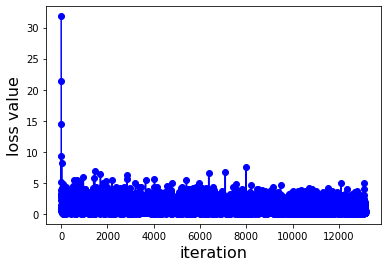

In [13]:
model.train(train, val, test)

We see that the model will automatically generate and plot the training process, along with the validation result and test result.

(**Model Prediction and Repuposing/Screening**) Next, we see how we can predict affinity scores on new data. Suppose the new data is a drug-target pair below.

In [21]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
y = [7.365]
X_pred = utils.data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='no_split')
y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [5.725095748901367]


We can also do repurposing and screening using the trained model. Basically, for repurposing a set of existing drugs (**r**) for a single new target (*t*), we run the above prediction function after pairing each repurposing drug with the target. Similarly, for screening, we instead have a set of drug-target pairs (**d**, **t**). We wrap the operation into a ```models.repurpose``` and ```models.virtual_screening``` methods.

For example, suppose we want to do repurposing from a set of antiviral drugs for a COVID-19 target 3CL protease. The corresponding data can be retrieved using ```dataset``` functions.


In [22]:
t, t_name = dataset.load_SARS_CoV2_Protease_3CL()
print('Target Name: ' + t_name)
print('Amino Acid Sequence: '+ t)

Target Name: SARS-CoV2 3CL Protease
Amino Acid Sequence: SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ


In [23]:
r, r_name, r_pubchem_cid = dataset.load_antiviral_drugs()
print("Total number of drugs to for repurposing: ", len(r))
print('Repurposing Drug 1 Name: ' + r_name[0])
print('Repurposing Drug 1 SMILES: ' + r[0])
print('Repurposing Drug 1 Pubchem CID: ' + str(r_pubchem_cid[0]))

Total number of drugs to for repurposing:  82
Repurposing Drug 1 Name: Abacavir
Repurposing Drug 1 SMILES: C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO
Repurposing Drug 1 Pubchem CID: 441300


Now, we can call the ```repurpose``` function. After feeding the necessary inputs, it will print a list of repurposed drugs ranked on its affinity to the target protein. The ```convert_y``` parameter should be set to be ```False``` when the ranking is ascending (i.e. lower value -> higher affinity) due to the log transformation, vice versus.

In [24]:
import numpy as np
r[27]

'CCC(C)C(C(=O)NC(CCC(=O)O)C(=O)NC(CCC(=O)O)C(=O)NC(CO)C(=O)NC(CCC(=O)N)C(=O)NC(CC(=O)N)C(=O)NC(CCC(=O)N)C(=O)NC(CCC(=O)N)C(=O)NC(CCC(=O)O)C(=O)NC(CCCCN)C(=O)NC(CC(=O)N)C(=O)NC(CCC(=O)O)C(=O)NC(CCC(=O)N)C(=O)NC(CCC(=O)O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCC(=O)O)C(=O)NC(CC(C)C)C(=O)NC(CC(=O)O)C(=O)NC(CCCCN)C(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)NC(C)C(=O)NC(CO)C(=O)NC(CC(C)C)C(=O)NC(CC3=CNC4=CC=CC=C43)C(=O)NC(CC(=O)N)C(=O)NC(CC5=CNC6=CC=CC=C65)C(=O)NC(CC7=CC=CC=C7)C(=O)N)NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(CC8=CN=CN8)NC(=O)C(C(C)CC)NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(C(C)O)NC(=O)C(CC9=CC=C(C=C9)O)NC(=O)C'

In [25]:
y_pred = models.repurpose(X_repurpose = np.concatenate([r[0:27], r[28:]]), target = t, model = model, drug_names = r_name, target_name = t_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
Drug Target Interaction Prediction Mode...
in total: 81 drug-target pairs
encoding drug...
unique drugs: 80
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |       Abacavir       | SARS-CoV2 3CL Protease |    3774.70    |
|  2   |      Aciclovir       | SARS-CoV2 3CL Protease |    3774.70    |
|  3   |       Adefovir       | SARS-CoV2 3CL Protease |    3774.70    |
|  4   |      Amantadine      | SARS-CoV2 3CL Protease |    3774.70    |
|  5   |      Amprenavir      | SARS-CoV2 3CL Protease |    3774.70    |
|  6   |       Arbidol        | SARS-CoV2 3CL Protease |    3774.70    |
|  7   |      Atazanavir      | SARS-CoV2 3CL Protease |    3774.70    |
|  8   |      

Now, let's move on to showcase how to do virtual screening. We first load a sample of data from BindingDB dataset. 

In [26]:
t, d = dataset.load_IC50_1000_Samples()

Downloading...


In [27]:
print("target length: ", len(t))
print("drug length: ", len(d))

target length:  100
drug length:  100


We can then use the ```virtual_screening``` function to generate a list of drug-target pairs that have high binding affinities. If no drug/target names are provided, the index of the drug/target list is used instead.

In [28]:
y_pred = models.virtual_screening(d, t, model)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 60  |  Target 60  |      6.28     |
|  2   |  Drug 21  |  Target 21  |      6.13     |
|  3   |  Drug 92  |  Target 92  |      5.82     |
|  4   |  Drug 20  |  Target 20  |      5.79     |
|  5   |  Drug 12  |  Target 12  |      5.75     |
|  6   |   Drug 0  |   Target 0  |      5.67     |
|  7   |   Drug 2  |   Target 2  |      5.65     |
|  8   |  Drug 87  |  Target 87  |      5.64     |
|  9   |   Drug 7  |   Target 7  |      5.61     |
|  10  |   Drug 8  |   Target 8  |      5.58     |
checkout ./result/virtual_screening.txt for the whole list



Saving and loading models are also really easy. The loading function also automatically detects if the model is trained on multiple GPUs. To save a model:

In [22]:
model.save_model('./model_tm_tm')

To load a saved/pretrained model:

In [20]:
model = models.model_pretrained(path_dir = './model_tm_tm')
model

We have also provided a list of pretrained model, you can find all available ones under the [list](https://github.com/kexinhuang12345/DeepPurpose#pretrained-models). For example, to load a MPNN+CNN model pretrained on BindingDB Kd dataset:

In [24]:
model = models.model_pretrained(model = 'MPNN_CNN_BindingDB')
model

Dataset already downloaded in the local system...


In [25]:
print(model.model_drug)
print("num of params: ", count_parameters(model.model_drug))
print("-"*40)
print(model.model_protein)
print("num of params: ", count_parameters(model.model_protein))

MPNN(
  (W_i): Linear(in_features=50, out_features=128, bias=False)
  (W_h): Linear(in_features=128, out_features=128, bias=False)
  (W_o): Linear(in_features=167, out_features=128, bias=True)
)
num of params:  44288
----------------------------------------
CNN(
  (conv): ModuleList(
    (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
    (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
    (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
  )
  (fc1): Linear(in_features=96, out_features=256, bias=True)
)
num of params:  118464


In [26]:
y_pred = models.repurpose(X_repurpose = np.concatenate([r[0:27], r[28:]]), target = t, model = model, drug_names = r_name, target_name = t_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
Drug Target Interaction Prediction Mode...
in total: 81 drug-target pairs
encoding drug...
unique drugs: 80
encoding protein...
unique target sequence: 74
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |      Entecavir       | SARS-CoV2 3CL Protease |      0.00     |
|  2   |     Methisazone      | SARS-CoV2 3CL Protease |      0.30     |
|  3   |      Aciclovir       | SARS-CoV2 3CL Protease |      0.77     |
|  4   |     Grazoprevir      | SARS-CoV2 3CL Protease |      4.50     |
|  5   |      Boceprevir      | SARS-CoV2 3CL Protease |      5.94     |
|  6   |       Loviride       | SARS-CoV2 3CL Protease |      7.85     |
|  7   |      Lamivudine      | SARS-CoV2 3CL Protease |     10.16     |
|  8   |     

In [27]:
y_pred = models.virtual_screening(d, t, model)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 40  |  Target 40  |     20.17     |
|  2   |  Drug 81  |  Target 81  |     12.67     |
|  3   |  Drug 87  |  Target 87  |     10.02     |
|  4   |  Drug 88  |  Target 88  |      9.62     |
|  5   |  Drug 37  |  Target 37  |      8.92     |
|  6   |  Drug 82  |  Target 82  |      8.81     |
|  7   |  Drug 90  |  Target 90  |      8.60     |
|  8   |  Drug 71  |  Target 71  |      8.42     |
|  9   |  Drug 14  |  Target 14  |      8.39     |
|  10  |  Drug 39  |  Target 39  |      8.24     |
checkout ./result/virtual_screening.txt for the whole list



In [29]:
model = models.model_pretrained(model = 'Transformer_CNN_BindingDB')
model

Dataset already downloaded in the local system...


In [30]:
print(model.model_drug)
print("num of params: ", count_parameters(model.model_drug))
print("-"*40)
print(model.model_protein)
print("num of params: ", count_parameters(model.model_protein))

transformer(
  (emb): Embeddings(
    (word_embeddings): Embedding(2586, 128)
    (position_embeddings): Embedding(50, 128)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder_MultipleLayers(
    (layer): ModuleList(
      (0): Encoder(
        (attention): Attention(
          (self): SelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): SelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): Intermediate(
          (dense): Linear(in_features=128, out_features=512, bias=True)
        )
        (output): Output(
  

In [31]:
y_pred = models.repurpose(X_repurpose = np.concatenate([r[0:27], r[28:]]), target = t, model = model, drug_names = r_name, target_name = t_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
Drug Target Interaction Prediction Mode...
in total: 81 drug-target pairs
encoding drug...
unique drugs: 80
encoding protein...
unique target sequence: 74
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |      Zidovudine      | SARS-CoV2 3CL Protease |      0.69     |
|  2   |      Moroxydine      | SARS-CoV2 3CL Protease |      1.73     |
|  3   |      Efavirenz       | SARS-CoV2 3CL Protease |      6.97     |
|  4   |      Tipranavir      | SARS-CoV2 3CL Protease |      9.22     |
|  5   |       Arbidol        | SARS-CoV2 3CL Protease |     11.61     |
|  6   |      Entecavir       | SARS-CoV2 3CL Protease |     17.38     |
|  7   |      Baloxavir       | SARS-CoV2 3CL Protease |     20.57     |
|  8   |     

We also provided many more functionalities for DTI research purposes. 

For example, this [demo](https://github.com/kexinhuang12345/DeepPurpose/blob/master/DEMO/Drug_Property_Pred-Ax-Hyperparam-Tune.ipynb) shows how to use Ax platform to do some latest hyperparameter tuning methods such as Bayesian Optimization on DeepPurpose.

Model robustness is very important for DTI task. One way to measure is to see how the model can predict drug or protein that do not exist in the training set, i.e., cold drug/target setting. You can achieve this by modifying the ```split_method``` parameter in the ```data_process``` function: 

In [33]:
y_pred = models.virtual_screening(d, t, model)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |   Drug 7  |   Target 7  |      9.01     |
|  2   |  Drug 37  |  Target 37  |      8.42     |
|  3   |  Drug 28  |  Target 28  |      8.02     |
|  4   |  Drug 72  |  Target 72  |      7.92     |
|  5   |  Drug 81  |  Target 81  |      7.88     |
|  6   |  Drug 97  |  Target 97  |      7.85     |
|  7   |  Drug 43  |  Target 43  |      7.79     |
|  8   |  Drug 79  |  Target 79  |      7.55     |
|  9   |  Drug 92  |  Target 92  |      7.54     |
|  10  |  Drug 15  |  Target 15  |      7.53     |
checkout ./result/virtual_screening.txt for the whole list



In [32]:
X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='cold_drug',frac=[0.7,0.1,0.2],
                                random_seed = 1)

Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.


That wraps up our tutorials on the main functionalities of DeepPurpose's Drug Target Interaction Prediction framework! 

Do checkout the upcoming tutorials:

Tutorial 2: Drug Property Prediction using DeepPurpose

Tutorial 3: Repurposing and Virtual Screening Using One Line of Code

**Star & watch & contribute to DeepPurpose's [github repository](https://github.com/kexinhuang12345/DeepPurpose)!**

Feedbacks would also be appreciated and you can send me an email (kexinhuang@hsph.harvard.edu)!